# A BERT-CNN based model trained on the Sentimental LIAR Dataset

The following work flow follows an implementation found in this paper: https://arxiv.org/abs/2009.01047   
and follows the implementation found here: https://github.com/UNHSAILLab/SentimentalLIAR

Ryan Hull, rhull8

In [13]:
# Install the required libraries and dependencies
%pip install -q transformers pandas torch scikit-learn numpy matplotlib sklearn

# Supress warnings for clean output
import warnings
warnings.filterwarnings('ignore')

In [14]:
import pandas as pd

# Import files
df=pd.read_csv("./train_final.csv")
test_df=pd.read_csv("./test_final.csv")
valid_df=pd.read_csv("./valid_final.csv")


# Truncate the data
print("before truncating size of data is :", df.shape, test_df.shape,valid_df.shape)
df=df[:10232]
test_df=test_df[:1264]
valid_df=valid_df[:1280]
print("size of data is :", df.shape, test_df.shape, valid_df.shape)

# Check if there are any null values in the dataframe
print("Any null in Subject? ",df['subject'].isnull().values.any())
print("Any null in Speaker? ",df['speaker'].isnull().values.any())
print("Any null in speaker_job? ",df['speaker_job'].isnull().values.any())
print("Any null in Party? ",df['party_affiliation'].isnull().values.any())
print("Any null in Context? ",df['context'].isnull().values.any())


before truncating size of data is : (10236, 31) (1267, 30) (1283, 31)
size of data is : (10232, 31) (1264, 30) (1280, 31)
Any null in Subject?  False
Any null in Speaker?  False
Any null in speaker_job?  True
Any null in Party?  False
Any null in Context?  True


In [15]:
# Initialize the column comment_text
df['comment_text']=""
test_df['comment_text']=""
valid_df["comment_text"]=""

# Combine all the columns into one for for ech dataframe
df['comment_text']=df['subject'].astype(str)+ ". "+ df["statement"]+\
df['speaker_id'].astype(str)+". "+df['speaker_job'].astype(str)+". "+ df['party_affiliation'].astype(str)\
+". "+df['context'].astype(str)+". "+df['sentiment_code'].astype(str)

test_df['comment_text']=test_df['subject'].astype(str)+ ". "+ test_df["statement"]+". "+\
test_df['speaker_id'].astype(str)+". "+test_df['speaker_job'].astype(str)+". "+ test_df['party_affiliation'].astype(str)\
+". "+test_df['context'].astype(str)+". "+df['sentiment_code'].astype(str)

valid_df['comment_text']=valid_df['subject'].astype(str)+ ". "+ valid_df["statement"]+\
valid_df['speaker_id'].astype(str)+". "+valid_df['speaker_job'].astype(str)+". "+ valid_df['party_affiliation'].astype(str)\
+". "+valid_df['context'].astype(str)+". "+valid_df['sentiment_code'].astype(str)


In [16]:
#c Concatenate emotion, speakers' credit and sentiment score togehter
df['emotion']="["+df['anger'].astype(str)+","+df['disgust'].astype(str)+","\
+df['fear'].astype(str)+","+df['joy'].astype(str)+","+df['sad'].astype(str)+","+\
df["barely_true_counts"].astype(str) +","+ df["false_counts"].astype(str)  +","+\
df["half_true_counts"].astype(str) + ","+df["mostly_true_counts"].astype(str) +","+ \
df["pants_on_fire_counts"].astype(str)+","+df["sentiment_score"].astype(str)+"]"

test_df['emotion']="["+test_df['anger'].astype(str)+","+test_df['disgust'].astype(str)+","\
+test_df['fear'].astype(str)+","+test_df['joy'].astype(str)+","+test_df['sad'].astype(str)\
+ ","+test_df["barely_true_counts"].astype(str) + ","+ test_df["false_counts"].astype(str) \
+","+ test_df["half_true_counts"].astype(str) +","+ test_df["mostly_true_counts"].astype(str)\
+","+ test_df["pants_on_fire_counts"].astype(str)+","+test_df["sentiment_score"].astype(str)+"]"

valid_df['emotion']="["+valid_df['anger'].astype(str)+","+valid_df['disgust'].astype(str)+","\
+valid_df['fear'].astype(str)+","+valid_df['joy'].astype(str)+","+valid_df['sad'].astype(str)\
+ ","+valid_df["barely_true_counts"].astype(str) + ","+ valid_df["false_counts"].astype(str) \
+","+ valid_df["half_true_counts"].astype(str) +","+ valid_df["mostly_true_counts"].astype(str)\
+","+ valid_df["pants_on_fire_counts"].astype(str)+","+valid_df["sentiment_score"].astype(str)+"]"



In [17]:
# Convert the data into a format that is compatible with the model

import ast
def convert_to_list(text):
  return ast.literal_eval(text)

for i in range(len(df["emotion"])):
  try:
    df["emotion"][i]=convert_to_list(df["emotion"][i])
  except:
    print(i,"====",df["emotion"][1])
    
for i in range(len(test_df["emotion"])):
  try:
    test_df["emotion"][i]=convert_to_list(test_df["emotion"][i])
  except:
    print(i,"====",test_df["emotion"][i], type(test_df["emotion"][i]))
    
for i in range(len(valid_df["emotion"])):
  try:
    valid_df["emotion"][i]=convert_to_list(valid_df["emotion"][i])
  except:
    print(i,"====",valid_df["emotion"][i], type(valid_df["emotion"][i]))    
    
df['list']=df['list'].apply(convert_to_list)
test_df['list']=test_df['list'].apply(convert_to_list)
valid_df['list']=valid_df['list'].apply(convert_to_list)

In [18]:
# Import the required libraries
import numpy as np
from sklearn import metrics
import transformers
import torch
from torch import cuda
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig

# Use the GPU if available else use the CPU
device = 'cuda' if cuda.is_available() else 'cpu'

# Training Parameters
MAX_LEN = 300
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 8
EPOCHS = 1
LEARNING_RATE = 1e-05
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [19]:
# Create a custom dataset class to hold the data in a format that BERT understands
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text = dataframe.comment_text
        self.targets = self.data.list
        self.max_len = max_len
        # Add emotion list from dataframe
        self.emotion=dataframe.emotion
        self.dfID=dataframe.ID

    def __len__(self):
        return len(self.comment_text)

    def __getitem__(self, index):
        comment_text = str(self.comment_text[index])
        comment_text = " ".join(comment_text.split())

        inputs = self.tokenizer.encode_plus(
            comment_text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float),
            'emotion':torch.tensor(self.emotion[index], dtype=torch.float),
            'dfID':self.dfID[index]
        }




In [20]:
# Create the dataset and dataloader for the neural network

train_size = 1
train_dataset=df.sample(frac=train_size,random_state=200).reset_index(drop=True)
test_dataset=test_df.sample(frac=train_size,random_state=200).reset_index(drop=True)
valid_dataset=valid_df.sample(frac=1,random_state=200).reset_index(drop=True)


print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))
print("VALID Dataset: {}".format(valid_dataset.shape))

training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_dataset, tokenizer, MAX_LEN)
valid_set= CustomDataset(valid_dataset, tokenizer, MAX_LEN)
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': 8,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)
valid_loader=DataLoader(valid_set,**test_params)

FULL Dataset: (10232, 33)
TRAIN Dataset: (10232, 33)
TEST Dataset: (1264, 32)
VALID Dataset: (1280, 33)


In [21]:
# Creating the customized model, by adding a drop out and a dense layer on top of BERT-base to get the final output for the model. 
class BERT_cnn_Class(torch.nn.Module):
    def __init__(self):
        super(BERT_cnn_Class, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.l2 = torch.nn.Dropout(0.3)
        
        self.l3=torch.nn.Conv1d(1, 50, kernel_size=20,stride=1)
        self.l4=torch.nn.Conv1d(50,100, kernel_size=20, stride=1)
        self.max_pooling=nn.MaxPool1d(2)
        self.l5=torch.nn.Linear(18000, 768)
        self.l6 = torch.nn.Linear(768, 2)
    # Define the forward pass
    def forward(self, ids, mask, token_type_ids,emotion):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        output_2 = self.l2(output_1) # Output from BERT
        # Feed into convolution network
        # First change the size to [8,1,768]        
        output_2=torch.cat((emotion,output_2),1) # concat the output of BERT with EMO+SPC+SEN (emotion, speakers' credit and sentiment score)
        output_2=output_2.unsqueeze(1)        
        output_3=self.l3(output_2)        
        output_3= self.max_pooling(output_3)
        output_4=self.l4(output_3)        
        output_4=self.max_pooling(output_4)
        # Change the shape to fit into linear function
        output_4=output_4.view(8,-1)
        output_5=self.l5(output_4)
        output_6=self.l6(output_5)        
        return output_6

model = BERT_cnn_Class()

# Put the model on to the GPU if available
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERT_cnn_Class(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affi

In [22]:
import time
import datetime
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))    
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [23]:
# Loss function (BCE) and Optimizer (Adam)
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [24]:
#TRAIN
val_losses=[]
train_losses=[]
accuracy_list=[]

for epoch in range(2):
  t0 = time.time()
  model.train()
  print(f"Epoch: {epoch}  is Started: ")
  batch=0
  train_loss=0
  
  for _,data in enumerate(training_loader, 0):
      try:
          ids = data['ids'].to(device, dtype = torch.long)
          mask = data['mask'].to(device, dtype = torch.long)
          token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
          targets = data['targets'].to(device, dtype = torch.float)
          emotions=data['emotion'].to(device,dtype=torch.float)
      except:
          print(f"some error at testing {batch}")
          print(data['dfID'] )
      try:  
        outputs = model(ids, mask, token_type_ids,emotions)
        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        train_loss+=loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch+=1
      except EOFError:
        print(f"{data['dfID']} error because of batch size-------->", EOFError)
        print(f"some error at testing {batch}")
        print(data['dfID'] )
  print(f"   Epoch: {epoch} Train loss is :{train_loss/batch}") 
  train_loss /=batch
  train_losses.append(train_loss)    
  print(f"   Epoch {epoch} took: {format_time(time.time() - t0)} \n")

  model.eval()
  fin_targets=[]
  fin_outputs=[]
  with torch.no_grad():
      val_loss, batch = 0, 1
      for _, data in enumerate(testing_loader, 0):
          ids = data['ids'].to(device, dtype = torch.long)
          mask = data['mask'].to(device, dtype = torch.long)
          token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
          targets = data['targets'].to(device, dtype = torch.float)
          emotions=data['emotion'].to(device,dtype=torch.float)
          batch+=1
          try:
                        outputs = model(ids, mask, token_type_ids,emotions)
                        loss = loss_fn(outputs, targets)
                        val_loss+=loss.item()
                        fin_targets.extend(targets.cpu().detach().numpy().tolist())
                        fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
          except:
            print(f"some error at testing {batch}")
            print(data['dfID'] )

      val_loss/=batch
      val_losses.append(val_loss)
  outputs=fin_outputs
  outputs = np.array(outputs) >= 0.5
  targets=fin_targets
  accuracy = metrics.accuracy_score(targets, outputs)
  accuracy_list.append(accuracy)
  f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
  f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
  print(f"Epoch: {epoch} - Accuracy on Testing Data Score = {accuracy}")
  print(f"Epoch: {epoch} - F1 Score on Testing Data (Micro) = {f1_score_micro}")
  print(f"Epoch: {epoch} - F1 Score on Testing Data (Macro) = {f1_score_macro}")
  print(f"\n Epoch {epoch} : Train Loss (Training Data):{train_loss}, Validation Loss (Testing Data): {val_loss}")
  print("_________________________________________________\n")
  

Epoch: 0  is Started: 
   Epoch: 0 Train loss is :0.6273025308995623
   Epoch 0 took: 0:04:48 

Epoch: 0 - Accuracy on Testing Data Score = 0.6431962025316456
Epoch: 0 - F1 Score on Testing Data (Micro) = 0.6458498023715414
Epoch: 0 - F1 Score on Testing Data (Macro) = 0.622172221884983

 Epoch 0 : Train Loss (Training Data):0.6273025308995623, Validation Loss (Testing Data): 0.6070349881858945
_________________________________________________

Epoch: 1  is Started: 
   Epoch: 1 Train loss is :0.5787981343896152
   Epoch 1 took: 0:04:49 

Epoch: 1 - Accuracy on Testing Data Score = 0.6716772151898734
Epoch: 1 - F1 Score on Testing Data (Micro) = 0.6724683544303798
Epoch: 1 - F1 Score on Testing Data (Macro) = 0.6309410968178741

 Epoch 1 : Train Loss (Training Data):0.5787981343896152, Validation Loss (Testing Data): 0.6106216946862778
_________________________________________________



In [25]:
from pandas import DataFrame
df=DataFrame(train_losses,columns=['train_losses'])
df=DataFrame(val_losses,columns=['val_losses'])
df.to_csv("./results.csv")


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


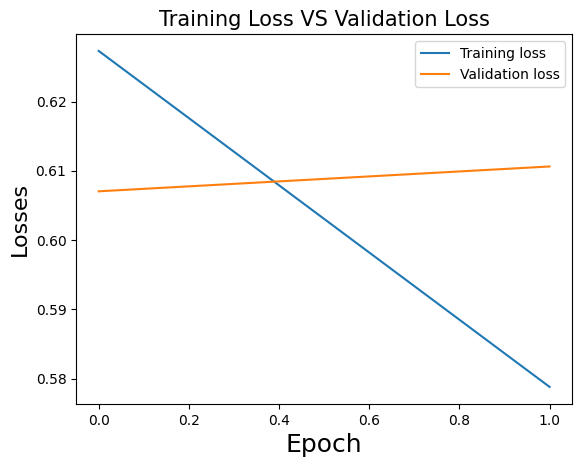

In [26]:


import matplotlib.pyplot as plt
plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")

plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Losses', fontsize=16)
plt.title('Training Loss VS Validation Loss', fontsize=15)

plt.legend()
plt.savefig('./results/epoch1.eps')

In [29]:
# Test on the validation dataset
model.eval()
fin_targets=[]
fin_outputs=[]

with torch.no_grad():
    c=0
    for _, data in enumerate(valid_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)
        emotions=data['emotion'].to(device,dtype=torch.float)
        c+=1
        try:
                      outputs = model(ids, mask, token_type_ids,emotions)
                      fin_targets.extend(targets.cpu().detach().numpy().tolist())
                      fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
        except EOFError:
          print(f"some error at {c}",EOFError)
outputs=fin_outputs
outputs = np.array(outputs) >= 0.5
targets=fin_targets
accuracy = metrics.accuracy_score(targets, outputs)

f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
print(f"Epoch:  {epoch}, Accuracy Score on validation data = {accuracy}")

print(f"Epoch:  {epoch}, F1 Score on Validation Data (Macro) = {f1_score_macro}")

Epoch:  1, Accuracy Score on validation data = 0.67734375
Epoch:  1, F1 Score on Validation Data (Macro) = 0.6167384049665088
